# Car Detection Using HOGs and SVM
***

# Table of Contents
***
1. [Introduction](#introduction)
2. [Exploring Data](#explore)
3. [Histogram of Oriented Gradients](#hogs)
4. [Linear SVC](#svc)
5. [Testing](#testing)
6. [Detection](#detection)
7. [Heatmap](#map)
8. [Live detection]((#live)
9. [Data Augmentation](#augment)
10. [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>
***
Humans rely on vision to walk, prepare food, watch TV and do hundreds of other tasks. Vision provides a large amount of information and how to act on it. This is why researchers have been trying to give computers the ability to see. This field is called computer vision. The goal is to give computers the ability to extract patterns and have a high-level understanding from digital images and videos.

Nowadays most smartphones have a really good camera that can capture photos with incredible fidelity and detail, even much better that humans. However, the problem is how good can a computer find patterns and understand what is infront of them. Working with unstructured data is a challenge since there are no given features for the machine learning algorithms to find patterns. Raw pixels by themselves do not give a clear idea of what is happening on the image. For that reason, feature extraction has been a technique used for several years to manually engineer features and find patterns in an image.

To tackle this problem, the project first explores the image data to check if the dataset is balanced. Then, it covers feature extraction using the algorithm of Histogram of Oriented Gradients and apply LinearSVC to classify the images. Finally, the project covers how to implement object detection to a live video using a sliding window and heatmaps. 

The data was collected from [GTI](https://www.gti.ssr.upm.es/data/Vehicle_database.html). The database comprises 3425 images of vehicle rears taken from different points of view, and 3900 images extracted from road sequences not containing vehicles.

## Exploring Data <a name="explore"></a>
***
These are some of the libraries used in this project.

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import time
import os

from sklearn.utils import shuffle
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label

The database separates images in four different regions according to the pose: middle/close range in front of the camera, middle/close range in the left, close/middle range in the right, and far range. Let's load all of the images and explore a bit more the data.

In [2]:
vehicles = pd.DataFrame(glob.glob('vehicles/*/*'))
vehicles[1] = 1

non_vehicles = pd.DataFrame(glob.glob('non-vehicles/*/*'))
non_vehicles[1] = 0

print('Vehicle images shape: ', vehicles.shape)
print('Non-vehicle images shape: ', non_vehicles.shape)

Vehicle images shape:  (3425, 2)
Non-vehicle images shape:  (3900, 2)


Let's explore the shape(pixels) of some of the images.

In [3]:
train_shape = [plt.imread(vehicles.iloc[i,0]).shape for i in range(len(vehicles))]
print('Maximum shape of images: {} \nMinimumshape of images: {}'.format(max(train_shape),
                                                                        min(train_shape)))

Maximum shape of images: (64, 64, 3) 
Minimumshape of images: (64, 64, 3)


In [4]:
train_shape = [plt.imread(non_vehicles.iloc[i,0]).shape for i in range(len(non_vehicles))]
print('Maximum shape of images: {} \nMinimumshape of images: {}'.format(max(train_shape),
                                                                        min(train_shape)))

Maximum shape of images: (64, 64, 3) 
Minimumshape of images: (64, 64, 3)


All of the images have 64x64 pixels and 3 channels, hue, saturation and lightning. 

In [5]:
image_df = pd.concat([vehicles,non_vehicles])
image_df.head()

,0,1
0,vehicles/Right/image0110.png,1
1,vehicles/Right/image0676.png,1
2,vehicles/Right/image0662.png,1
3,vehicles/Right/image0104.png,1
4,vehicles/Right/image0892.png,1


In [6]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7325 entries, 0 to 3899
Data columns (total 2 columns):
0    7325 non-null object
1    7325 non-null int64
dtypes: int64(1), object(1)
memory usage: 171.7+ KB


Now let's look at several images to have a better understanding of the data.

In [7]:
def create_subplots(images,nrows,ncols,axis='off',figsize=(20,15)):
    plt.figure(figsize=figsize)
    for i,each in enumerate(images):
        plt.subplot(nrows,ncols,i+1)
        plt.imshow(each)
        plt.axis(axis)

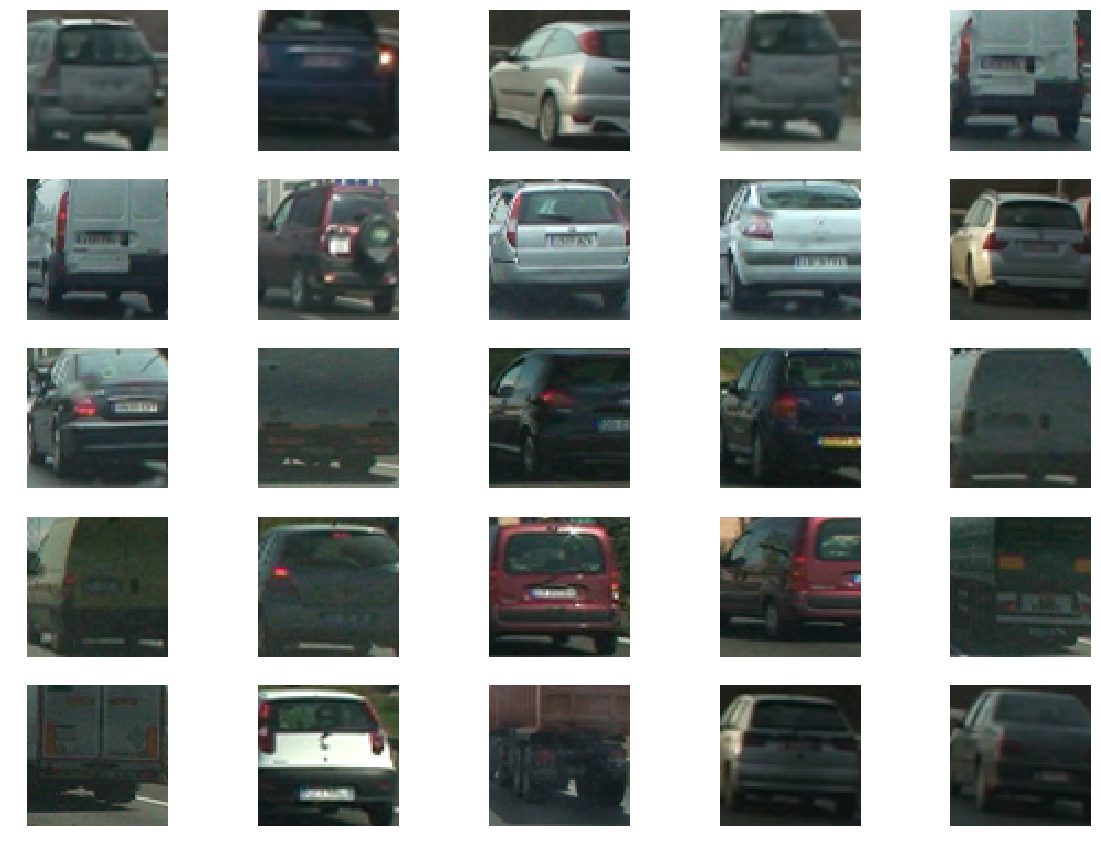

In [8]:
im = [plt.imread(image_df.iloc[i,0]) for i in range(len(image_df.iloc[:25,0]))]
create_subplots(im,5,5)

Important takeaways from the data:

- The data has several images of cars with different make, models, shapes and colors.
- The object(car) to analyze is positioned in slightly different angles.
- Most images have almost no background area.

Before continuing with preprocessing and feature extraction, let's shuffle the data and leave 5% of the data for final testing and use 95% for training and testing the classifier.

In [9]:
seed = np.random.RandomState(seed=52)

image_df = shuffle(image_df,random_state=seed)
test_image_df = image_df[0:round(len(image_df)*0.05)]
image_df = image_df[round(len(image_df)*0.05):]
print('Using {} images for training and testing \
the model and leaving {} for final testing'.format(len(image_df),len(test_image_df)))

Using 6959 images for training and testing the model and leaving 366 for final testing


## Histogram of Oriented Gradients <a name="hogs"></a>
***
The main focus of this section is to give structure to the unstructured data that images have and train an SVM model. Histogram of Oriented Gradients is just one way of approaching this problem. First, let's use some preprocessing techniques on the unstructured data. Different preprocessing techniques can give different results. A combination of different color spaces, resizing and canny edges are some of the techniques that can be implemented. In this project, let's focus on color space with the goal of improving accuracy as much as possible.

After preprocessing the data, the HOGs algorithm will help with the feature extraction process. A feature descriptor is a representation of an image that simplifies the image by extracting useful information and throwing away extraneous information. This technique counts occurrences of gradient orientation in localized portions of an image. A gradient is a directional change in image intensity or color. So it basically counts the times there is a change on intensity or color in a block with a specific size in the image.

In [10]:
def set_color_space(image,color_space='yuv'):
    """Convert image/frame to different colorspace.
    Options available: yuv,hls,hsv,rgb.
    
    Keyword arguments:
    image -- image/frame to change colorspace
    color_space -- set colorspace to apply to image/frame.
    """
    if color_space == 'yuv':
        image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    elif color_space == 'hls':
        image = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    elif color_space == 'hsv':
        image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    elif color_space == 'rgb':
        image = image
    else:
        raise Exception('ERROR:', 'color_space not found.')
    
    return image

It is important to extract the features of each channel of the frame as well for exploring purposes let's create a method to return the image representation of the feature vector. 

In [11]:
def preprocess_extract(frame,params):
    """ Returns the feature vector for 3 channels of the image plus each
    image representation of the vector.
    
    Keyword arguments:
    image -- image/frame to change colorspace
    params -- parameter for the chosen colorspace.
    """
    preprocessed_img = set_color_space(frame,color_space=params['color_space'])

    hogA, hogA_img = perform_hog(preprocessed_img[:, :, 0],params)
    hogB, hogB_img = perform_hog(preprocessed_img[:, :, 1],params)
    hogC, hogC_img = perform_hog(preprocessed_img[:, :, 2],params)
    
    return hogA, hogB, hogC, hogA_img, hogB_img, hogC_img

In [12]:
def perform_hog(frame, p):
    """Implements the HOGs algorithm using the skimage implementation.
    
    Keyword arguments:
    image -- image/frame to extract features and image representation.
    params -- parameters needed for skimage.feature.hog(). This
    includes orientations, pixels_per_cell, etc.
    """
    feat, hg_img = hog(frame, orientations=p['orientations'],
                       pixels_per_cell=p['pixels_per_cell'],
                       cells_per_block=p['cells_per_block'],
                       transform_sqrt=p['transform_sqrt'],
                       block_norm=p['block_norm'],
                       visualise=p['visualise'],
                       feature_vector=p['feature_vector'])

    return feat,hg_img 

In [13]:
def combine_channels(params, hogA, hogB, hogC, x_pix, 
                     y_pix, w_pix = None, h_pix = None):
    """Combine the 3 channels of image as one feature vector.
    
    Keyword arguments:
    params -- dictionary with pixels_per_cell value and
    bounding_box
    hogA -- feature vector for channel 1 
    hogB -- feature vector for channel 2
    hogC -- feature vector for channel 3
    x_pix -- starting x coordinate pixel of feature vector
    y_pix -- starting y coordinate pixel of feature vector
    w_pix -- width pixel size of feature vector. If None, 
    bounding_box parameter will be used
    h_pix -- height pixel size of feature vector. If None, 
    bounding_box parameter will be used
    """
        
    if h_pix is None and w_pix is None: 
        h_pix, w_pix = params['bounding_box'], params['bounding_box']
    
    height = h_pix // params['pixels_per_cell'][0]
    width = w_pix // params['pixels_per_cell'][0]
    y_start = y_pix // params['pixels_per_cell'][0]
    x_start = x_pix // params['pixels_per_cell'][0]
    y_end = y_start + height - 1
    x_end = x_start + width - 1

    hogA = hogA[y_start: y_end, x_start: x_end].ravel()
    hogB = hogB[y_start: y_end, x_start: x_end].ravel()
    hogC = hogC[y_start: y_end, x_start: x_end].ravel()
    hog = np.hstack((hogA, hogB, hogC))

    return hog

In [14]:
def get_features(frame, params):
    ''' Preprocess image, extract features of 3 channels
    and combine the channels into one feature vector.
    
    Keyword arguments:
    image -- image/frame to extract features and image representation.
    params -- dictionary needed for skimage.feature.hog() and colorspace
    '''
    hogA, hogB, hogC, _, _, _, = preprocess_extract(frame,params)
    return combine_channels(params,hogA,hogB,hogC,0,0,frame.shape[1],frame.shape[0])

Now let's implement all the methods to extract the features of the 3 channels of the image and plot each vector representation. The following parameters can be tuned as needed: 

- color_space: different color spaces will give different feature vectors and consequently influencing the accuracy of the model.
- pixels_per_cell: The size of descriptor typically is much smaller than the number of pixels in an image. The pixels per cell are chosen based on the scale of the features important to do the classification. A low amount of pixels would blow up the size of the feature vector and a very large one may not capture relevant information. For now, let's use 16x16. 
- cells_per_block: A large block size makes local changes less significant while a smaller block size weights local changes more. The notion of blocks exist to tackle illumination variation. Let's use the typical value which is 2 x pixels_per_cell.
- orientations: sets the number of bins in the histogram of gradients. The authors of the HOG paper(Dalal and Triggs) recommended a value of 9 to capture gradients between 0 and 180 degrees in 20 degrees increments for pedestrian detection. Let's use 11 bins in this project and tune if necessary this would be increments of 16.36 degrees. 
- transform_sqrt: Apply power law compression to normalize the image before processing. It helps with reducing the effects of local shadowing and illumination variations.
- block_norm: Applies a normalization method. Let's use L2-Hys which is L2 Norm, followed by limiting the maximum values to 0.2.
- visualise: to create an image representation for the feature vector. Should be True in this project. 
- bounding_box: this is the size of the images. Since the images in the dataset are 64x64 let's set the value to 64.

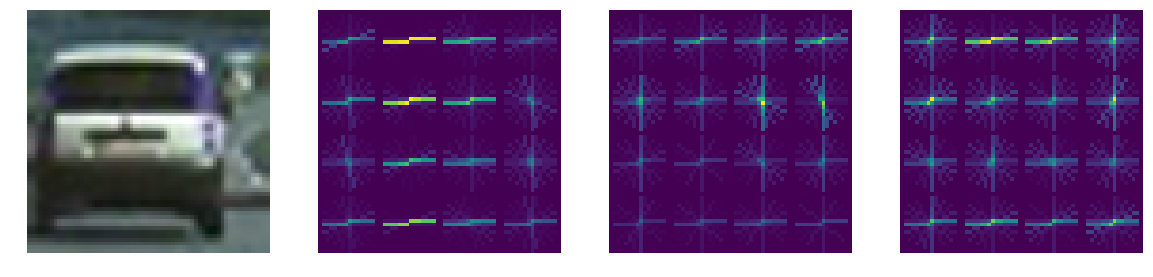

In [15]:
params = {
    'color_space': 'yuv',
    'orientations': 11, 
    'pixels_per_cell': (16,16),          
    'cells_per_block': (2,2),           
    'transform_sqrt': True,
    'block_norm': 'L2-Hys',
    'visualise': True,
    'feature_vector':False,
    'bounding_box': 64
}

im = cv2.imread(image_df.iloc[0,0])
_,_,_,img1,img2,img3 = preprocess_extract(im,params)
plot_images = [im,img1,img2,img3]

create_subplots(plot_images,1,4)

Above images show the original image plus the 3 channel feature representation. Basically, it calculated the features in a block with 4 cells, each cell of size 16x16. 

## Linear SVC <a name="svc"></a>
***
HOG descriptors are not tied to only be used with Support Vector Machine. However, LinearSVM is widely use due to having a very fast computation. As well, it does work well for sparse feature spaces. Let's not tune the parameters for now and see what kind of accuracy the classifier has. 

In [16]:
features = []

print('[Info] Extracting features...')
for i in range(len(image_df)):
    img = cv2.imread(image_df.iloc[i,0])
    features.append(get_features(img,params))

print('...Done')
features = np.asarray(features)
print('Features shape: ', features.shape,'\n')

unscaled_x = (features).astype(np.float64)
scaler = StandardScaler()
x = scaler.fit_transform(unscaled_x)
y = np.array(image_df[1])

print('[Info] Training classifier...')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, 
                                                    random_state = seed)
svc = LinearSVC()
svc.fit(x_train, y_train)
accuracy = svc.score(x_test, y_test)

print('...Done')
print('Accuracy: ', np.round(accuracy, 4))

[Info] Extracting features...
...Done
Features shape:  (6959, 1188) 

[Info] Training classifier...
...Done
Accuracy:  0.9468


Each image has a feature vector size of 1188. The classifier has **94.61%** accuracy with no tuning of the hyperparameters.

## Testing <a name="testing"></a>
***
There was a 5% of images left for final testing. So let's test on data that the classifier has not seen and see if the images are predicted correctly.

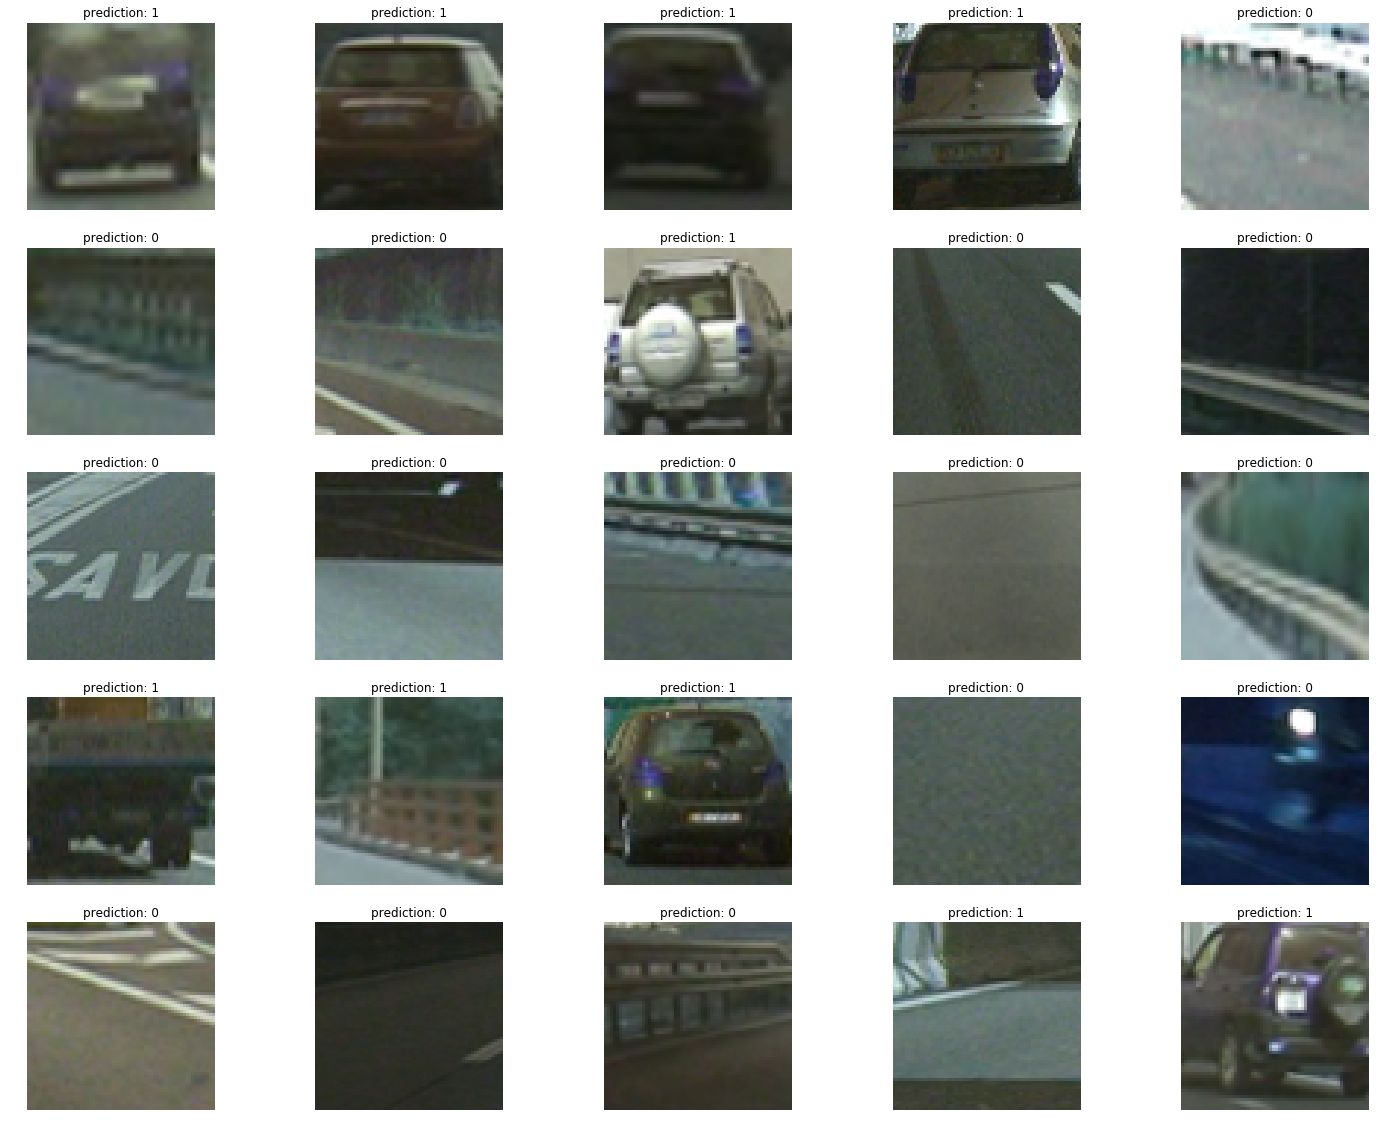

In [17]:
plt.figure(figsize=(25,20))
for i in range(len(test_image_df[:25])):
    img = cv2.imread(test_image_df.iloc[i,0])
    feat = get_features(img,params)
    feat = np.asarray([feat]).astype(np.float64)
    feat_scaled = scaler.transform(feat)
    pred = svc.predict(feat_scaled)
    plt.subplot(5,5,i+1)
    plt.imshow(img)
    plt.title('prediction: '+str(pred[0]))
    plt.axis('off')

Of all the 25 images, 2 were incorrectly predicted by the classifier. 

## Detection <a name="detection"></a>
***
The test video was recorded with an iphone and then converted to *.avi* file. Let's retrieve the first frame and plot the original frame and the HOGs represetation of the 3 channels. 

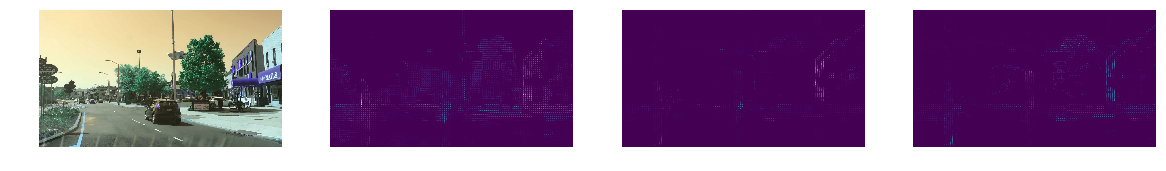

In [18]:
_,frame = cv2.VideoCapture('output.avi').read(1)
_,_,_,img1,img2,img3 = preprocess_extract(frame,params)
plot_images = [frame,img1,img2,img3]

create_subplots(plot_images,1,4)

The whole image was preprocessed and then extracted the features of each channel. However, in this project, it is highly improbable that the target object will be at the top of the frame. The approach that we will take is to extract features only of a small window on the image. This will cause the detection to be quicker due to less pixels to analyze.  

In [19]:
def get_strip(frame,window_size,start_strip,height):
    '''Get a smaller frame size. Returns new frame pixels, 
    the width of new frame and scale of new frame.
    
    Keyword arguments:
    frame -- image/frame to extract a smaller frame
    window_size -- window height cropped from original frame
    start_strip -- starting y-coordinate point of original frame
    to start the new frame extraction
    height -- height of the new strip
    '''
    scale = window_size / height
    y_end = start_strip + window_size 
    w = np.int(frame.shape[1] / scale)

    strip = frame[start_strip:(start_strip+window_size),:,:]
    strip = cv2.resize(strip, (w, height))
    x_end = (strip.shape[1] // height - 1) * height
    
    return strip, x_end, scale

In [20]:
def get_bouding_boxes(strip,x_end,scale,hog_params,increment,scaler,svc,ss,ws):
    ''' Get feature vector and apply bounding boxes were object is
    detected.
    
    Keyword arguments:
    strip -- image/frame to apply bounding boxes
    x_end -- width of frame
    scale -- scale that original frame was downsized
    hog_params -- dictionary needed for skimage.feature.hog()
    increment -- value that the sliding window will move across frame
    scaler -- StandardScaler()
    svc -- classifier
    ss -- starting y-coordinate point of original frame
    ws -- window height cropped from original frame
    '''
    hogA, hogB, hogC, _, _, _, = preprocess_extract(strip,hog_params)
    boxes = []
    for resized_x in range(0, x_end, increment):
        features = combine_channels(hog_params,hogA,hogB,hogC,resized_x, 0)
        trans = scaler.transform([features])
        pred = svc.predict(trans)
        
        if pred[0]: 
            x = np.int(scale * resized_x)
            boxes.append((x, ss, ws))

    return boxes

In [21]:
def detect_object(frame,hog_params,ws,ss,height,increment,scaler,svc):
    '''Combines get_strip and get_bouding_boxes to detect 
    objects on frame. As well, draws a rectangle on original frame
    using the proper coordinates. Returns a copy of frame.
    '''
    strip, x_end, scale = get_strip(frame,ws,ss,height)
    boxes = get_bouding_boxes(strip,x_end,scale,hog_params,increment,scaler,svc,ss,ws)
    frame_copy = frame.copy()
    for box in boxes:
        cv2.rectangle(frame_copy, (box[0], box[1]), (box[0] + box[2], box[1] + box[2]), (255,0,0), thickness=5)
        
    return frame_copy

Now let's use the first frame of the test video and see if the classifier using histogram of oriented gradients is able to correctly detect the object on frame.

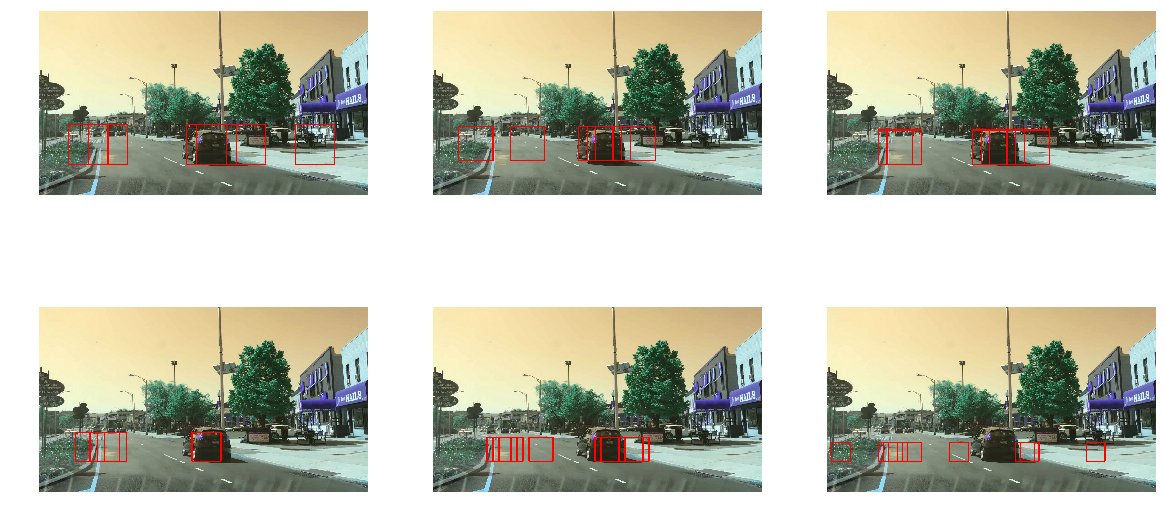

In [22]:
ss = [670, 680, 700, 730, 760, 790]
ws = [230, 200, 200, 170, 140, 110]
height = 64
increment = 16
img = []

for ss, ws in zip(ss, ws):
    frame_copy = detect_object(frame,params,ws,ss,height,increment,scaler,svc)
    img.append(frame_copy)

create_subplots(img,2,3,figsize=(20,10))

Looks like different window sizes and starting points perform better. However, all options have False Positives. Also, it is important to mention that when the object is correctly detected, it tends to draw more than one bounding box. So let's try first to combine all bounding boxes into one and analyze the results.

## Heatmap <a name="map"></a>
***
Now let's create a heat map of recurring detections frame by frame to follow and detect vehicles. Basically, the more bounding boxes on the frame the more likely it is a True Positive. As well, add a threshold to reject areas affected by False Positives.

In [23]:
def draw(frame, memory, thresh,mapp,thresholded_map,samples_found):
    '''Draw the bounding box on detected object and return
    new frame.  
    
    Keyword arguments:
    frame -- frame to apply heatmap
    memory -- buffer of frames. 
    thresh -- threshold to reject areas affected by FP
    mapp -- a copy of one frame channel filled with zero values
    samples_found -- number of samples_found on frame
    '''
    this_frame = frame.copy()
    thresholded_map = np.copy(mapp)
    thresholded_map[mapp < thresh] = 0
    labeled = label(thresholded_map)
    samples_found = labeled[1]
    labeled_map = labeled[0]
    this_map = labeled_map
    for n in range(1, samples_found + 1):
        coords =  (this_map == n).nonzero()
        xs, ys = np.array(coords[1]), np.array(coords[0])
        p1 = (np.min(xs), np.min(ys))
        p2 = (np.max(xs), np.max(ys))
        cv2.rectangle(this_frame, p1, p2, (0, 225, 0), thickness = 10)
    
    return this_frame

In [24]:
def remove_boxes(boxes,mapp):
    '''Remove bounding boxes.'''
    for box in boxes: 
        x1, y1, x2, y2 = box_boundaries(box)    
        mapp[y1: y2, x1: x2] -= 1

In [25]:
def add_boxes(boxes,mapp): 
    '''Add bounding boxes.'''
    for box in boxes: 
        x1, y1, x2, y2 = box_boundaries(box)
        mapp[y1: y2, x1: x2] += 1

In [26]:
def box_boundaries(box):
    '''Return the coordinates of each box.'''
    x1, y1 = box[0], box[1]
    x2, y2 = box[0] + box[2], box[1] + box[2]  
    return x1, y1, x2, y2

In [27]:
blank= None
thresholded_map= None
mapp = None
thresh = None
samples_found = 0
history = []
memory = None

def heatmap_test(this_frame,clf,scaler,ws, ss,increment,thresh=5,memory=4):
    
    blank = np.zeros_like(this_frame[:, :, 0]).astype(np.float)
    mapp = np.copy(blank)
    thresh = thresh
    memory = memory    
    history = []
    for sz, pos in zip(ws, ss):
        
        strip, x_end, scale = get_strip(frame,sz,pos,height)
        bounding_boxes = get_bouding_boxes(strip,x_end,scale,params,increment,scaler,clf,pos,sz)
        if len(history) == memory:
            remove_boxes(history[0])
            history = history[1:]
            print(history)

        add_boxes(bounding_boxes,mapp)
        history.append(bounding_boxes)

    new_frame = draw(this_frame,memory,thresh,mapp,thresholded_map,samples_found)
    return  new_frame

Remember that the more window sizes we have, memory variables has to go up. Let's try a variation of window sizes and positions and check the resulst on the first frame.

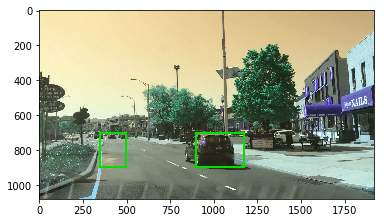

In [28]:
window_sizes = [100,200,200,200]
window_positions = [720,700,700,700]
# window_positions = [670, 680, 700, 700, 760, 790]
# window_sizes = [230, 200, 200, 200, 140, 110]
_,frame = cv2.VideoCapture('output.avi').read(1)

a = heatmap_test(frame,svc,scaler,window_sizes, window_positions,increment)
plt.imshow(a)

The heatmap reduces the amount of bounding boxes on frame. It correctly detected the object and it shows a False Positive on the frame. So it reduced the amount of false positives and also overlapping boxes.

## Live Detection <a name="live"></a>
***
Finally, let's try it on a short video and see how it performs.

In [30]:
cap = cv2.VideoCapture('output.avi')
ws = 160
ss = 400
height = 64
increment = 16

window_sizes = 130,160,160,180
window_positions = 420,400,400,380

while cap.isOpened():
    ret, frame = cap.read()
    if ret:
        frame = cv2.resize(frame, None,fx=0.6, fy=0.6, interpolation = cv2.INTER_LINEAR)
        frame_copy = heatmap_test(frame,svc,scaler,window_sizes, window_positions,increment)
        cv2.imshow('Car Detection', frame_copy)

        if cv2.waitKey(1) == 13:
            break
    else:
        break
        
cap.release()
cv2.destroyAllWindows()

With a lower threshold, the classifier tends to predict more times the location of the object. However, false positives are still high at times. So let's try reducing **FP** and increase the rate of detection by doing data augmentation.

## Data Augmentation <a name="augment"></a>
***
Data augmentation is another way we can reduce overfitting on models, where we increase the amount of training data. Let's change the color space of the dataset 3 times to increase the dataset by 3. We will apply *hls*, *hsv*, and *yuv* and see what kind of results we can get.

In [31]:
params_hls = {
    'color_space': 'hls',
    'orientations': 11, 
    'pixels_per_cell': (16,16),          
    'cells_per_block': (2,2),           
    'transform_sqrt': True,
    'block_norm': 'L2-Hys',
    'visualise': True,
    'feature_vector':False,
    'bounding_box': 64
}

features_hls = []

print('[Info] Extracting features...')
for i in range(len(image_df)):
    img = cv2.imread(image_df.iloc[i,0])
    features_hls.append(get_features(img,params_hls))

print('...Done')
features_hls = np.asarray(features_hls)
print('Features shape: ', features_hls.shape)

[Info] Extracting features...
...Done
Features shape:  (6959, 1188)


In [32]:
params_yuv = {
    'color_space': 'yuv',
    'orientations': 11, 
    'pixels_per_cell': (16,16),          
    'cells_per_block': (2,2),           
    'transform_sqrt': True,
    'block_norm': 'L2-Hys',
    'visualise': True,
    'feature_vector':False,
    'bounding_box': 64
}

features_yuv = []

print('[Info] Extracting features...')
for i in range(len(image_df)):
    img = cv2.imread(image_df.iloc[i,0])
    features_yuv.append(get_features(img,params_yuv))

print('...Done')
features_yuv = np.asarray(features_yuv)
print('Features shape: ', features_yuv.shape)

[Info] Extracting features...
...Done
Features shape:  (6959, 1188)


In [33]:
params_hsv = {
    'color_space': 'hsv',
    'orientations': 11, 
    'pixels_per_cell': (16,16),          
    'cells_per_block': (2,2),           
    'transform_sqrt': True,
    'block_norm': 'L2-Hys',
    'visualise': True,
    'feature_vector':False,
    'bounding_box': 64
}

features_hsv = []

print('[Info] Extracting features...')
for i in range(len(image_df)):
    img = cv2.imread(image_df.iloc[i,0])
    features_hsv.append(get_features(img,params_hsv))

print('...Done')
features_hsv = np.asarray(features_hsv)
print('Features shape: ', features_hsv.shape)

[Info] Extracting features...
...Done
Features shape:  (6959, 1188)


In [34]:
print(features_hls[0])
print(features_yuv[0])
print(features_hsv[0])

[ 0.11074921  0.00729761  0.07132863 ...,  0.23424933  0.14234819
  0.2002188 ]
[ 0.01682586  0.00594713  0.01277703 ...,  2.24849542  0.88751064  0.        ]
[ 0.11354005  0.00732231  0.07198748 ...,  0.05182093  0.0396404   0.1454201 ]


The first image is the same for the 3 lists and since the color space was changed for each image, the result is a different feature vector. Now let's stack them and train the classifier with the same dataset  but with different color space.

In [35]:
final_features = np.vstack((features_hls,features_yuv,features_hsv))
print('Features shape: ', final_features.shape)

y = np.hstack((image_df[1],image_df[1],image_df[1]))
print('Labels: ', len(y))

Features shape:  (20877, 1188)
Labels:  20877


In [36]:
unscaled_x = (final_features).astype(np.float64)
scaler_2 = StandardScaler()
x = scaler_2.fit_transform(unscaled_x)

print('[Info] Training classifier...')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, 
                                                    random_state = seed)
svc2 = LinearSVC()
svc2.fit(x_train, y_train)
accuracy = svc2.score(x_test, y_test)

print('...Done')
print('Accuracy: ', np.round(accuracy, 4))

[Info] Training classifier...
...Done
Accuracy:  0.9382


Training LinearSVC with double the amount of negative samples and the same number of positive samples gives a slightly worse accuracy at **93.82%**. Now let's see if this improves our live detection.

In [37]:
cap = cv2.VideoCapture('output.avi')
height = 64
increment = 16

# window_sizes = 190,190,180,160
# window_positions = 380,380,400,420

window_sizes = 190,190,180,160,140,120
window_positions = 380,380,400,420,440, 460

# window_sizes = 130,160,160,180,160,160
# window_positions = 420,400,400,380,400,400

while cap.isOpened():
    ret, frame = cap.read()
    if ret:
        frame = cv2.resize(frame, None,fx=0.6, fy=0.6, interpolation = cv2.INTER_LINEAR)
        frame_copy = heatmap_test(frame,svc2,scaler_2,window_sizes, window_positions,increment,thresh=6,
                                 memory=6)
        cv2.imshow('Car Detection', frame_copy)

        if cv2.waitKey(1) == 13:
            break
    else:
        break
        
cap.release()
cv2.destroyAllWindows()

Detection of cars on the road increased and FP decreased. However, there is still a lot room for improvement. Let's keep in mind that different window size, window position, threshold and memory can make the classifier perform better or worse. 

## Conclusion <a name="conclusion"></a>
***
Humans usually can focus only one point at a time. However, computers can basically analyze all frames on an image and focus on several objects at a time. This makes computer vision really exciting problem to solve. Still, this is a hard task for machines. HOGs and LinearSVC has been a good combination to tackle this problem. This is just one of the possible solutions for object detection.

In summary, the project covered feature extraction of a frame. Then, training of a classifier such as LinearSVC chosen for being a fast at this task. After classifying and testing, it was time to use the classifier in a live video with different type of frames that is used to see. This created high FP and sometimes not detecting the object on the frame. Data augmentation helped in reducing FP and improving object detection.  

There is still room for improvement. The following are some ideas to improve this project:

- Better bounding box clustering
- More data with more positive and negative images
- Better data augmentation such doing mirroring or resizing images
- A better sample video with less objects on frame
- Better parameter tuning